# i. Perkenalan

**Nama** : Alfarabi

**Dataset** : [Credit Card Default](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=green-reporter-417802&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default)

**Hugging Face** : (https://huggingface.co/spaces/Alfarabi58/Predict_Credit_Card_Default?logs=container)

**Problem Statement** : Dataset ini berfokus pada masalah default kartu kredit, yaitu situasi di mana pemegang kartu kredit gagal melakukan pembayaran tepat waktu. Masalah ini memiliki konsekuensi keuangan serius baik bagi perusahaan penerbit kartu kredit maupun bagi pemegang kartu. Fenomena default kartu kredit dapat menjadi perhatian serius dalam industri keuangan karena dapat mengakibatkan kerugian finansial yang signifikan. Identifikasi pola atau faktor yang mempengaruhi default kartu kredit dapat membantu perusahaan dan lembaga keuangan dalam pengambilan keputusan yang lebih baik terkait manajemen risiko, penilaian kredit, dan pencegahan kerugian.

**Objective** : Mengidentifikasi pola atau faktor-faktor yang mempengaruhi default kartu kredit. Dengan memahami dan menganalisis pola default credit card menggunakan machine learning diharapkan dapat ditemukan wawasan yang dapat mendukung pengambilan keputusan yang lebih baik dalam industri keuangan.

# ii. Query SQL

```sql
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "green-reporter-417802"
client = bigquery.Client(project=project_id)```

```sql 
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

# Query untuk mengambil data dari BigQuery
df = client.query('''
    SELECT 
        limit_balance,
        CAST(sex AS INT64) AS sex,
        CAST(education_level AS INT64) AS education_level,
        CAST(marital_status AS INT64) AS marital_status,
        age,
        pay_0,
        pay_2,
        pay_3,
        pay_4,
        CAST(pay_5 AS FLOAT64) AS pay_5,
        CAST(pay_6 AS FLOAT64) AS pay_6,
        bill_amt_1,
        bill_amt_2,
        bill_amt_3,
        bill_amt_4,
        bill_amt_5,
        bill_amt_6,
        pay_amt_1,
        pay_amt_2,
        pay_amt_3,
        pay_amt_4,
        pay_amt_5,
        pay_amt_6,
        CAST(default_payment_next_month AS INT64) AS default_payment_next_month
    FROM 
        `bigquery-public-data.ml_datasets.credit_card_default`
    LIMIT 9990
    ''').to_dataframe()```

# iii. Import Libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import phik
from scipy.stats import skew

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting data
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Model definition
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from feature_engine.outliers import Winsorizer


# Hyperparameter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Import kfold
from sklearn.model_selection import StratifiedKFold

# Model Saving
import pickle

# Warning
import warnings 
warnings.filterwarnings("ignore")

# iv. Data Loading

Data yang diambil merupakan dataset credit card yang akan di evaluasi dengan menggunakan **Logistic Regression**, **SVM**, dan **KNN**.

In [2]:
# Load dataset
df_ori = pd.read_csv('dataset_credit_card.csv')

# Duplicate dataset
df = df_ori.copy()

# Show 5 data
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


Pertama saya akan melakukan pengecekan dataframe.

In [3]:
# Check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

Informasi yang didapatkan dari data diatas adalah:  
- 2965 entries
- 24 columns

Lalu saya akan melakukan pengecekan duplikat pada data.

In [4]:
# Cek duplikasi data
df.duplicated().sum()

1

Setelah melakukan pengecekan duplitkat terdapat 1 data duplikat, lalu saya akan menghapus data duplikat tersebut.

In [5]:
# Menghapus baris duplikat dari dataframe 'df'
df.drop_duplicates()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


Setelah dilakukan drop terdapat perbedaan jumlah baris yang sebelumnya 2965 menjadi 2964.

Kemudian saya akan mengecek missing value pada dataframe.

In [6]:
# Cek missing value
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Informasi diatas menunjukan bahwa tidak ada missing value dari masing-masing kolom.

Lalu saya mengecek statistik deskriptif pada dataframe.

In [7]:
# Menampilkan ringkasan statistik deskriptif dari DataFrame df
df.describe()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,...,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,...,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,...,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


Informasi diatas menunjukan nilai count, mean, std, min, 25%, 50%, 75%, max dari setiap kolom.

Setelah itu saya mengecek nama kolom yang ada di dataframe.

In [8]:
# Cek nama kolom
df.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

Berikut adalah deksripsi dari kolom yang ada di dataframe.

| Column | Description |
| --- | --- |
| limit_balance | Amount of given credit in NT dollars (includes individual and family/supplementary credit) |
| sex | Gender (1=male, 2=female) |
| education_level | Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) |
| marital_status | Marital status (1=married, 2=single, 3=others) |
| age | Age in years |
| pay_0 | Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above) |
| pay_2 | Repayment status in August, 2005 (scale same as above) |
| pay_3 | Repayment status in July, 2005 (scale same as above) |
| pay_4 | Repayment status in June, 2005 (scale same as above) |
| pay_5 | Repayment status in May, 2005 (scale same as above) |
| pay_6 | Repayment status in April, 2005 (scale same as above) |
| bill_amt_1 | Amount of bill statement in September, 2005 (NT dollar) |
| bill_amt_2 | Amount of bill statement in August, 2005 (NT dollar) |
| bill_amt_3 | Amount of bill statement in July, 2005 (NT dollar) |
| bill_amt_4 | Amount of bill statement in June, 2005 (NT dollar) |
| bill_amt_5 | Amount of bill statement in May, 2005 (NT dollar) |
| bill_amt_6 | Amount of bill statement in April, 2005 (NT dollar) |
| pay_amt_1 | Amount of previous payment in September, 2005 (NT dollar) |
| pay_amt_2 | Amount of previous payment in August, 2005 (NT dollar) |
| pay_amt_3 | Amount of previous payment in July, 2005 (NT dollar) |
| pay_amt_4 | Amount of previous payment in June, 2005 (NT dollar) |
| pay_amt_5 | Amount of previous payment in May, 2005 (NT dollar) |
| pay_amt_6 | Amount of previous payment in April, 2005 (NT dollar) |
| default_payment_next_month | Default payment (1=yes, 0=no) |

# v. Exploratory Data Analysis (EDA)

Kemudian saya akan melakukan explorasi data.

1. Objective: Melihat distribusi default payment next month.

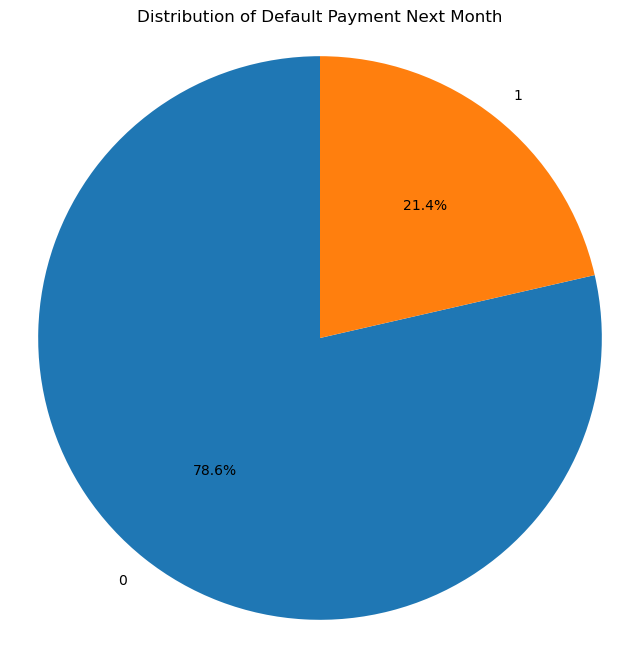

In [9]:
# Hitung distribusi kelas target
class_distribution = df['default_payment_next_month'].value_counts()

# Plot pie chart untuk distribusi kelas
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Default Payment Next Month')
plt.axis('equal')  # Menjadikan pie chart berbentuk lingkaran
plt.show()

Berdasarkan pie chart sebagian besar (78,6%) pembayaran diperkirakan akan berhasil bulan depan dan sisanya sebanyak 21,4% dari pembayaran diperkirakan akan mengalami kegagalan.

2. Objective: Melihat distribusi usia berdasarkan pengguna credit card.

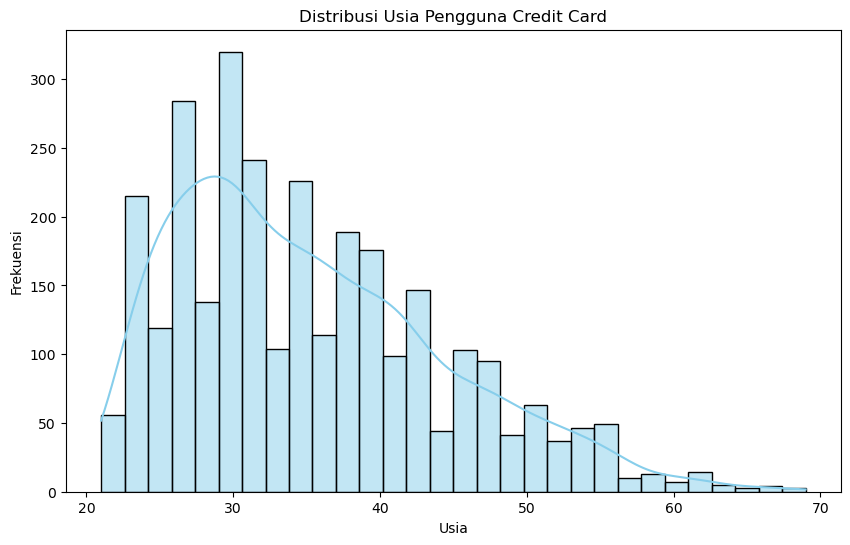

In [10]:
# Visualisasi : Histogram Usia (Age)
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Usia Pengguna Credit Card')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.show()

Informasi yang didapat dari histogram diatas menunjukan bahwa usia pengguna credit card terbanyak yaitu pada usia 30 tahun.

3. Objective: Melihat hubungan limit balance per default payment next month.

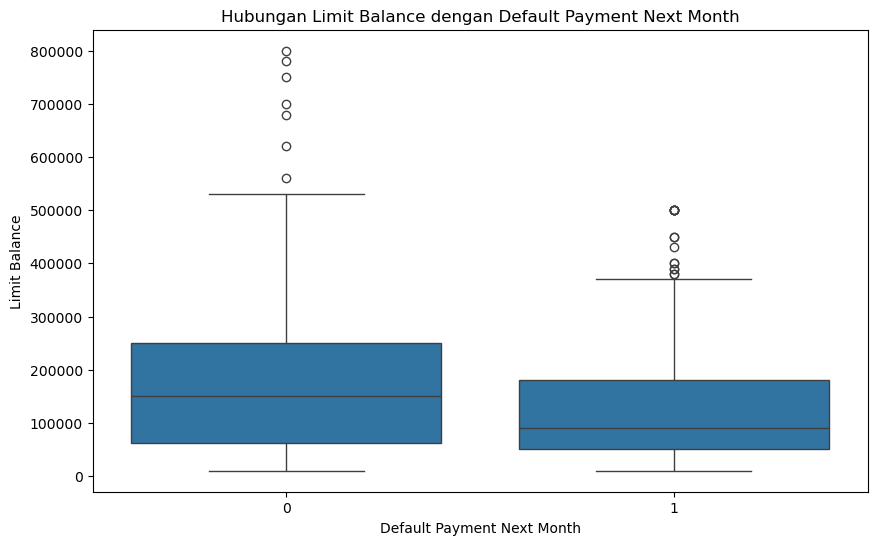

In [11]:
# Visualisasi : Boxplot Limit Balance per Default Payment Next Month
plt.figure(figsize=(10, 6))
sns.boxplot(x='default_payment_next_month', y='limit_balance', data=df)
plt.title('Hubungan Limit Balance dengan Default Payment Next Month')
plt.xlabel('Default Payment Next Month')
plt.ylabel('Limit Balance')
plt.show()

Berdasarkan boxplot diatas semakin tinggi saldo limit semakin besar kemungkinan pembayaran yang gagal bulan depan. Jika saldo limit adalah 800.000 ada kemungkinan besar pembayaran yang gagal bulan depan. Sebaliknya jika saldo limit adalah 0 tidak ada kemungkinan pembayaran gagal bulan depan.

4. Objective: Melihat persebaran data berdasarkan Bill Amount & Payment Amount pada bulan pertama.

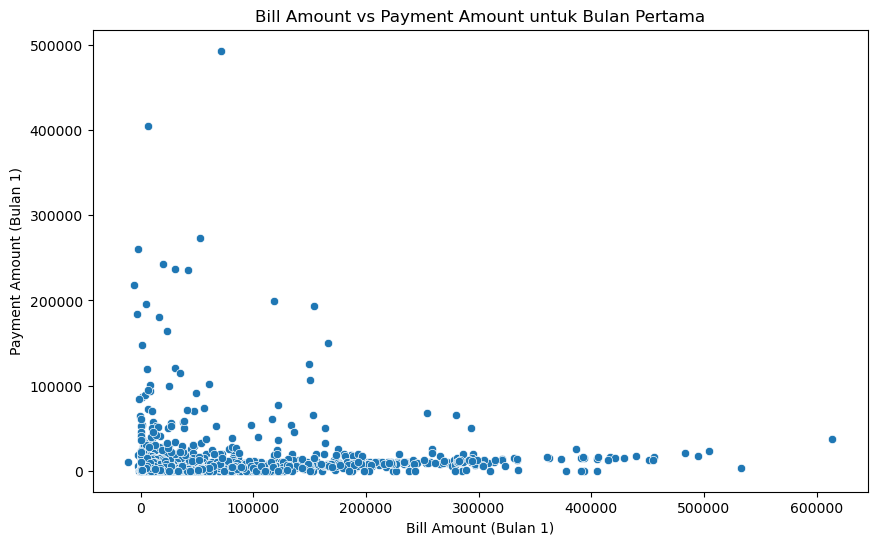

In [12]:
# Visualisasi : Scatterplot Bill Amount vs Payment Amount untuk Bulan Pertama (Bill_amt_1 vs Pay_amt_1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bill_amt_1', y='pay_amt_1', data=df)
plt.title('Bill Amount vs Payment Amount untuk Bulan Pertama')
plt.xlabel('Bill Amount (Bulan 1)')
plt.ylabel('Payment Amount (Bulan 1)')
plt.show()

Berdasarkan scatter plot diatas terdapat hubungan positif antara bill amount dengan payment amount pada bulan pertama. Hal ini berarti semakin tinggi jumlah tagihan semakin tinggi pula jumlah pembayaran yang dilakukan.

5. Objective: Melihat pengguna credit card berdasarkan education level.

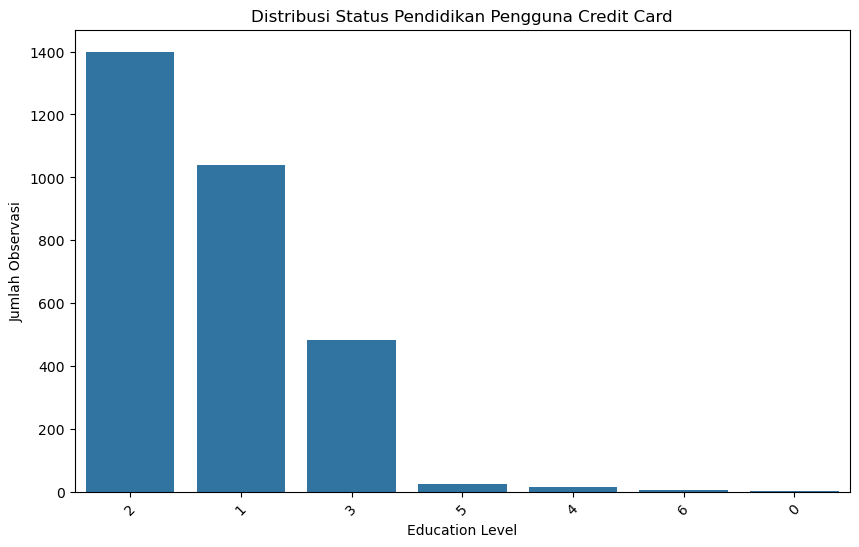

In [13]:
# Visualisasi : Bar Plot Status Pendidikan (Education Level)
edu_counts = df['education_level'].value_counts()

# Plot Bar Plot untuk distribusi status pendidikan
plt.figure(figsize=(10, 6))
sns.countplot(x='education_level', data=df, order=edu_counts.index)
plt.title('Distribusi Status Pendidikan Pengguna Credit Card')
plt.xlabel('Education Level')
plt.ylabel('Jumlah Observasi')
plt.xticks(rotation=45)  # Rotasi label sumbu x untuk memperbaiki tampilan
plt.show()

Informasi yang didapat dari bar plot diatas menunjukan education level terbanyak yang menggunakan credit card. Pengguna credit card terbanyak terletak pada education level 2 (University).

# vi. Feature Engineering

Pada proses ini dataset akan dipisahkan menjadi fitur `X(Variabel)` dan fitur `y(Target)`.

Setelah dipisahkan menjadi fitur X dan y akan dibagi lagi menjadi `Train-set` dan `Test-set`.  

Sebelum membagi data, dataset akan dimasukan kedalam variabel baru yaitu data_inf.

In [14]:
# Menyimpan 1 data random dari data asli untuk digunakan sebagai data inference ke dalam variabel data_inf
data_inf = df.sample(1, random_state=0)

# Menghapus data inference dari df
df.drop(data_inf.index, inplace=True)

# Melakukan reset index untuk data_inf dan df
df.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

# Menghapus target di data_inf
data_inf.drop(['default_payment_next_month'], axis=1, inplace=True)

Lalu dataset disimpan ke dalam bentuk CSV.

In [15]:
# Simpan ke csv
data_inf.to_csv('data_inf.csv')

### Split Between `X` (Features/Variables) and `y` (Target/Label)

Saya memilih `default_payment_next_month` menjadi variabel dependen, lalu memasukan variabel selain default_payment_next_month sebagai variabel independen.

In [16]:
# Splitting feature X & y
X= df.drop('default_payment_next_month', axis=1)
y = df['default_payment_next_month']

In [17]:
# Menampilkan 5 data teratas dari variabel X
X.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0


In [18]:
# Menampilkan 5 data teratas dari variabel y
y.head()

0    1
1    0
2    1
3    0
4    0
Name: default_payment_next_month, dtype: int64

### Split Between Train-set and Test-set

Lalu saya akan membagi menjadi `Train-set` dan `Test-set` untuk dilakukan evaluasi.

In [19]:
# Splitting between train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 11, stratify=y)

# Print Test set and Train set size
print('X Train size : ', X_train.shape)
print('X Test size : ', X_test.shape)
print('y Train size : ', y_train.shape)
print('y Test size : ', y_test.shape)

X Train size :  (2667, 23)
X Test size :  (297, 23)
y Train size :  (2667,)
y Test size :  (297,)


In [20]:
# Menampilkan 5 data teratas dari X_train
X_train.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1969,240000.0,2,2,1,38.0,1.0,2.0,-1.0,2.0,2.0,...,189.0,189.0,1648.0,1459.0,899.0,198.0,0.0,1459.0,0.0,1250.0
1693,180000.0,2,1,1,53.0,-1.0,-1.0,-1.0,0.0,0.0,...,29366.0,5400.0,0.0,1599.0,1260.0,29366.0,54.0,0.0,1599.0,0.0
1194,50000.0,2,3,2,22.0,0.0,0.0,0.0,0.0,0.0,...,52148.0,32718.0,32096.0,30563.0,20007.0,3014.0,1309.0,5009.0,2008.0,4622.0
1831,50000.0,1,1,2,26.0,1.0,2.0,2.0,2.0,2.0,...,41167.0,41890.0,42605.0,41792.0,3000.0,1900.0,1700.0,1700.0,0.0,2500.0
255,100000.0,2,1,1,38.0,0.0,0.0,0.0,0.0,0.0,...,68566.0,65132.0,48738.0,51020.0,3000.0,5000.0,2436.0,3000.0,3000.0,2000.0


In [21]:
# Menampilkan 5 data teratas dari X_test
X_test.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
2540,350000.0,1,1,1,49.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,1518.0,4625.0,363.0,858.0,4213.0,1529.0,4713.0,363.0,858.0,566.0
2497,270000.0,2,2,1,35.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,165.0,165.0,0.0,601.0,165.0,165.0,165.0,0.0,601.0,928.0
679,120000.0,2,2,2,37.0,0.0,0.0,0.0,0.0,0.0,...,99051.0,99927.0,101541.0,103379.0,4848.0,4877.0,3625.0,3600.0,3751.0,3900.0
1055,180000.0,1,2,1,40.0,1.0,2.0,0.0,0.0,0.0,...,130083.0,64398.0,62277.0,58216.0,1000.0,4052.0,2293.0,2295.0,2400.0,2110.0
262,100000.0,2,1,2,27.0,0.0,0.0,0.0,0.0,0.0,...,78343.0,79111.0,79993.0,81279.0,3000.0,3400.0,3000.0,3000.0,3000.0,3000.0


Setelah itu saya memisahkan antara `categorical` dengan `numereical` pada X_train ke dalam variable baru.

In [22]:
# Split kolom numerical dan categorical
cat_col = X_train.select_dtypes(include='object').columns.tolist()
num_col = X_train.select_dtypes(exclude='object').columns.tolist()

Disini saya melakukan looping dengan bertujuan untuk memisahkan numerical dan categorical untuk dilakukan handling outlier dengan asumsi jumlah unique value yang dibawah 11 tidak akan dilakukan handling outlier.

In [23]:
numerical = []
categorical_num = []

# Loop melalui setiap kolom numerik dalam num_col
for i in num_col:
    if X_train[i].nunique()>11:
        numerical.append(i)
    else:
        categorical_num.append(i)

# Cetak daftar kolom numerik dan kolom numerical dan categorical
print(f'numerical columns: {numerical}')
print(print(f'categorical numeric columns: {categorical_num}'))

numerical columns: ['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
categorical numeric columns: ['sex', 'education_level', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
None


### Handling Outlier

Lalu saya akan melakukan handling outlier pada X_train untuk melihat apakah ada data yang tidak sesuai dengan data yang seharusnya.

In [24]:
# Inisialisasi daftar untuk menampung fitur dengan tingkat skewness
normal = []
skew = []
extreme_skew = []

# Iterasi melalui fitur numerik
for i in numerical:
    # Menghitung skewness dari setiap fitur
    skewness = X_train[i].skew()
    # Memisahkan fitur berdasarkan tingkat skewness
    if -0.5 < skewness < 0.5:
        normal.append(i)
    elif -1 <= skewness <= -0.5 or 0.5 <= skewness <=1:
        skew.append(i)
    elif skewness < 1 or skewness > 1:
        extreme_skew.append(i)

# Menampilkan hasil klasifikasi fitur berdasarkan skewness
print('normal:', normal)
print('skew:', skew)
print('extreme skew:', extreme_skew)

normal: []
skew: ['age']
extreme skew: ['limit_balance', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


Dari data diatas terdapat `skew` dan `extreme skew` pada X_train maka akan dilakukan handling outlier.

Setelah itu saya melakukan `capping` terhadap nilai skew dan extreme skew pada X_train, dikarenakan jika melakukan drop data yang akan dihapus melebihi 5%.

In [25]:
# Capping the skewed distribution
winsoriser_skewed = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=skew)

# Capping the extreme skewed distribution
winsoriser_extream_skewed = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=extreme_skew)

In [26]:
# Menggunakan Winsorizer untuk mengatasi skewed pada X_train dan X_test
X_train = winsoriser_skewed.fit_transform(X_train)

# Menggunakan Winsorizer untuk mengatasi extreme skewed pada X_train dan X_test
X_train = winsoriser_extream_skewed.fit_transform(X_train)

### Missing Value Handling

Pada proses handling missing value ini saya hanya akan pengecekan missing value, dikarenakan tidak adanya missing value pada dataset.

In [27]:
# Check missing value in X_train
X_train.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [28]:
# Check missing value in X_test
X_test.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [29]:
# Check missing value in y_test
y_test.isnull().sum()

0

In [30]:
# Check missing value in y_train
y_train.isnull().sum()

0

### Feature Selection

Pada proses ini saya akan mengecek korelasi pada variabel independen terhadap variabel dependen untuk melakukan `feature selection`.

#### Correlation for Feature Selection

Saya akan melakukan pengecekan korelasi dengan menggunakan fungsi `phik_matix`.

In [31]:
# Menggabungkan data pelatihan (fitur dari set_1 dan target)
combined_train_data = pd.concat([X_train, y_train], axis=1)
phik_overview = combined_train_data.phik_matrix()
phik_overview ['default_payment_next_month']

interval columns not set, guessing: ['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']


limit_balance                 0.204852
sex                           0.000000
education_level               0.082427
marital_status                0.039454
age                           0.041598
pay_0                         0.594911
pay_2                         0.466395
pay_3                         0.333710
pay_4                         0.423419
pay_5                         0.422944
pay_6                         0.394252
bill_amt_1                    0.083305
bill_amt_2                    0.091290
bill_amt_3                    0.047981
bill_amt_4                    0.068587
bill_amt_5                    0.053063
bill_amt_6                    0.041598
pay_amt_1                     0.168630
pay_amt_2                     0.191199
pay_amt_3                     0.141073
pay_amt_4                     0.148800
pay_amt_5                     0.146262
pay_amt_6                     0.162483
default_payment_next_month    1.000000
Name: default_payment_next_month, dtype: float64

Lalu saya mengambil nilai korelasi dengan `threshold >30%`.

In [32]:
# Menggambil korelasi dengan threshold 20%
phik_overview['default_payment_next_month']
features =[]
for i in X_train.columns.tolist():
    if phik_overview['default_payment_next_month'][i]> 0.3:
        features.append(i)
        
features

['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

Setelah itu saya memasukan hasil feature selection kedalam varibel baru.

In [33]:
# Variable baru untuk dimasukan ke X_train
X_train_features = X_train[features]
X_test_features = X_test[features]

In [34]:
# Menampilkan lima baris pertama dari X_train_features
X_train_features.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
1969,1.0,2.0,-1.0,2.0,2.0,2.0
1693,-1.0,-1.0,-1.0,0.0,0.0,-1.0
1194,0.0,0.0,0.0,0.0,0.0,0.0
1831,1.0,2.0,2.0,2.0,2.0,2.0
255,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Menampilkan lima baris pertama dari X_test_features
X_test_features.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
2540,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2497,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
679,0.0,0.0,0.0,0.0,0.0,0.0
1055,1.0,2.0,0.0,0.0,0.0,0.0
262,0.0,0.0,0.0,0.0,0.0,0.0


### Split Between Numerical and Categorical Column

Kemudian saya akan memisahkan antara `numerical` dan `categorical` setelah dilakukan proses feature selection.

In [36]:
# List of numerical features
num_col_features = []
print(f'numerical columns: {num_col_features}')

# List of categorical ordinal features
cat_ordinal_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
print(f'categorical ordinal columns: {cat_ordinal_features}')

numerical columns: []
categorical ordinal columns: ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


Setelah dipisahkan menjadi numerical dan categorical, saya akan memasukannya ke dalam X_train dan X_test.

In [37]:
# Split train test based on column types
X_train_num = X_train_features[num_col_features]
X_test_num = X_test_features[num_col_features]

X_train_cat = X_train_features[cat_ordinal_features]
X_test_cat = X_test_features[cat_ordinal_features]

In [38]:
# Cek value 5 teratas dari X_train_num
X_train_num.head()

""
1969
1693
1194
1831
255


In [39]:
# Cek value 5 teratas dari X_train_cat
X_train_cat.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
1969,1.0,2.0,-1.0,2.0,2.0,2.0
1693,-1.0,-1.0,-1.0,0.0,0.0,-1.0
1194,0.0,0.0,0.0,0.0,0.0,0.0
1831,1.0,2.0,2.0,2.0,2.0,2.0
255,0.0,0.0,0.0,0.0,0.0,0.0


Lalu saya akan menggabungkan kedua file ke dalam variabel `X_train_final` dan `X_test_final`.

In [40]:
# Gabungkan kolom numerik dan kategorikal menjadi X_train_final
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)

# Gabungkan kolom numerik dan kategorikal menjadi X_test_final
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

In [41]:
# Menampilkan lima baris pertama dari X_train_final
X_train_final.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
1969,1.0,2.0,-1.0,2.0,2.0,2.0
1693,-1.0,-1.0,-1.0,0.0,0.0,-1.0
1194,0.0,0.0,0.0,0.0,0.0,0.0
1831,1.0,2.0,2.0,2.0,2.0,2.0
255,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Menampilkan lima baris pertama dari X_test_final
X_test_final.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
2540,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2497,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
679,0.0,0.0,0.0,0.0,0.0,0.0
1055,1.0,2.0,0.0,0.0,0.0,0.0
262,0.0,0.0,0.0,0.0,0.0,0.0


# vii. Model Definiton

Lalu saya akan melakukan `pipeline` dengan tujuan menggabungkan preprocess dengan model `Logistic Regression, KNN, SVC`.

### Pipe Line

In [43]:
# Column transformer
preprocess = ColumnTransformer(transformers=[], remainder='passthrough') # untuk kolom yang tidak ditransformasi

### Pipe Line Logistic Regression

In [44]:
# Create pipeline for Logistic Regression
pipe_log = make_pipeline(preprocess, LogisticRegression())

### Pipe Line KNN

In [45]:
# Create pipeline for KNN
pipe_knn = make_pipeline(preprocess, KNeighborsClassifier())

### Pipe Line SVM

In [46]:
# Create pipeline for SVC
pipe_svc = make_pipeline(preprocess, SVC())

# viii. Model Training

### Cross Validation

Saya akan melakukan `cross validation` untuk mencari model terbaik antara Logistic regression, KNN, dan SVM dengan mengunakan parameter `n_splits=5` atau dengan kelipatan 5 dan menggunakan metrik `F1 score`.

In [47]:
# Inisialisasi StratifiedKFold dengan 5 lipatan
skfold = StratifiedKFold(n_splits=5)

### Cross Validation Logistic Regression

In [48]:
# Melakukan cross validation logistic regression dengan StratifiedKFold dan menghitung skor F1
cv_log = cross_val_score(pipe_log, X_train_final, y_train, cv=skfold, scoring='f1', n_jobs=-1)

### Cross Validation KNN

In [49]:
# Melakukan cross validation knn dengan StratifiedKFold dan menghitung skor F1
cv_knn = cross_val_score(pipe_knn, X_train_final, y_train, cv=skfold, scoring='f1', n_jobs=-1)

### Cross Validation SVM

In [50]:
# Melakukan cross validation svm dengan StratifiedKFold dan menghitung skor F1
cv_svc = cross_val_score(pipe_svc, X_train_final, y_train, cv=skfold, scoring='f1', n_jobs=-1)

# ix. Model Evaluation

Kemudian saya akan melakukan perbadingan model dengan tujuan untuk menemukan best model antara Logistic regression, KNN, dan SVM dengan menggunakan cross validation.

In [51]:
# Finding best model on cross_val_score (mean)
name_model = []
cv_score = 0

# Iterating through cross-validation scores and model names
for cv,name in zip([cv_log,cv_svc,cv_knn],
                   ['Log','SVC','KNN']):
    print(name)
    print('f1 score - All - Cross Validation', cv)
    print('f1 score - Mean - Cross Validation', cv.mean())
    print('f1 score - STD - Cross Validation', cv.std())
    print('f1 score - Range - Cross Validation', (cv.mean() - cv.std()), '-', (cv.mean() + cv.std()))
    print('-'*50)
     # Comparing the mean cross-validation score with the current best score
    if cv.mean() > cv_score:
        cv_score = cv.mean()
        name_model = name
    else:
        pass


# Displaying the best model and its score
print('Best Model: ', name_model)
print('Best Model Score is ', cv_score)

Log
f1 score - All - Cross Validation [0.46857143 0.43870968 0.36363636 0.32167832 0.38461538]
f1 score - Mean - Cross Validation 0.3954422351841707
f1 score - STD - Cross Validation 0.05251647280025337
f1 score - Range - Cross Validation 0.34292576238391737 - 0.44795870798442405
--------------------------------------------------
SVC
f1 score - All - Cross Validation [0.47513812 0.54166667 0.58757062 0.43636364 0.5       ]
f1 score - Mean - Cross Validation 0.5081478092092382
f1 score - STD - Cross Validation 0.052422305668651345
f1 score - Range - Cross Validation 0.45572550354058683 - 0.5605701148778895
--------------------------------------------------
KNN
f1 score - All - Cross Validation [0.44692737 0.48421053 0.52356021 0.38636364 0.42639594]
f1 score - Mean - Cross Validation 0.453491537098296
f1 score - STD - Cross Validation 0.047194681611244994
f1 score - Range - Cross Validation 0.40629685548705097 - 0.500686218709541
--------------------------------------------------
Best M

Dari hasil perbadingan antara Logistic regression, KNN, dan SVM  dengan menggunakan cross validation, best model yang ditemukan adalah `SVM` dengan score **mean 0.5081478092092382**.

In [52]:
# Fit pipeline pada data pelatihan
pipe_svc.fit(X_train_final, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('svc', SVC())])

### Before Hyperparameter Tuning

Kemudian saya akan mengecek nilai F1 score dari `best model (SVM)` untuk melakukan perbandingan dengan hasil setelah dilakukan proses `Hyperparameter tuning`.

F1 Score - Train Set   :  0.5340782122905028 

F1 Score - Test Set   :  0.54 

Confusion Matrix      : 
Confusion Matrix      : 


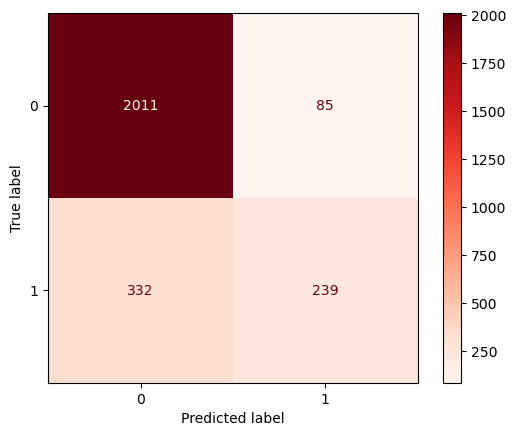

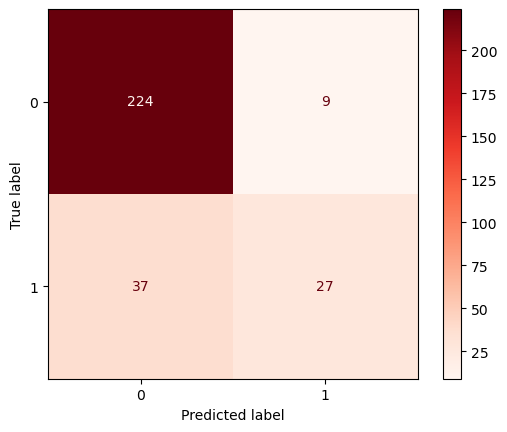

In [53]:
# Lakukan prediksi pada data pelatihan dan data uji
y_pred_train_svc = pipe_svc.predict(X_train_final)

# Lakukan prediksi pada data pelatihan dan data uji
y_pred_test_svc = pipe_svc.predict(X_test_final)

# Tampilkan classification report untuk data pelatihan
print('F1 Score - Train Set   : ', f1_score(y_train, y_pred_train_svc), '\n')

# Tampilkan classification report untuk data uji
print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test_svc), '\n')

# Check Performance Model against Train-Set
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_svc, X_train_final, y_train, cmap='Reds'))

# Check Performance Model against Test-Set
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test_final, y_test, cmap='Reds'))

In [54]:
# Save Classification Report into a Dictionary
all_reports = {}
def performance_report(all_reports, y_train, y_pred_train_svc, y_test, y_pred_test_svc, name):
  score_reports = {
      'train - f1_score' : f1_score(y_train, y_pred_train_svc),
      'test - f1_score' : f1_score(y_test, y_pred_test_svc),
  }
  all_reports[name] = score_reports
  return all_reports

all_reports = performance_report(all_reports, y_train, y_pred_train_svc, y_test, y_pred_test_svc, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
train - f1_score,0.534078
test - f1_score,0.540000


Dari proses diatas dapat dilihat nilai F1 score sebelum dilakukan Hyperparameter tuning:
- **F1 Score - Train Set**   :  0.5340782122905028 
- **F1 Score - Test Set**   :  0.54

### Hyperparameter Tuning

Lalu saya akan melakukan hyperparameter tuning dengan menggunakan `GridSearch` yang bertujuan untuk meningkatkan score dari best model (SVM). 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameter:
{'svc__C': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'} 

F1 Score - Train Set (Best SVC)  :  0.5527192008879024 

F1 Score - Test Set (Best SVC)   :  0.5454545454545454 

Confusion Matrix      : 
Confusion Matrix      : 


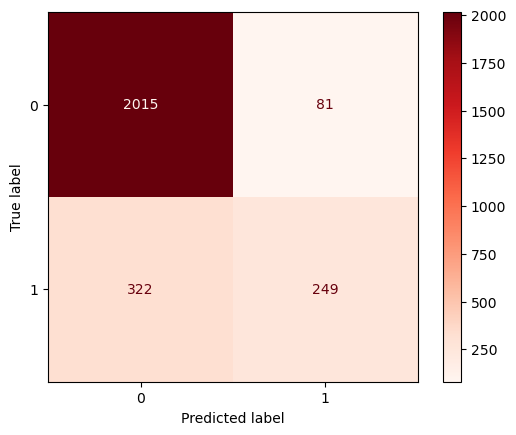

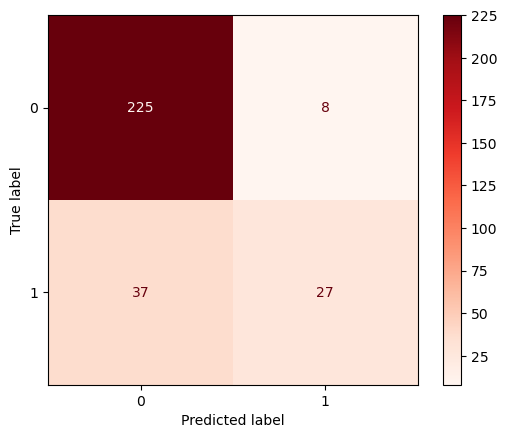

In [61]:
    # Daftar hyperparameter yang akan dioptimalkan
    param_grid = {
                'svc__C': [1,2,3,4,5,6,7,8,9,10],
                'svc__kernel': ['linear','rbf', 'sigmoid'],
                'svc__gamma': ['scaled','auto']
    }

    # Inisialisasi GridSearchCV untuk pencarian parameter terbaik
    grid_search = GridSearchCV(pipe_svc, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

    # Lakukan grid search untuk mencari kombinasi parameter terbaik
    grid_search.fit(X_train_final, y_train)

    # Dapatkan parameter terbaik setelah grid search selesai
    best_params = grid_search.best_params_
    print("Best Parameter:")
    print(best_params, '\n')

    # Prediksi menggunakan model dengan parameter terbaik
    best_svc = grid_search.best_estimator_

    # Prediksi menggunakan model terbaik pada data pelatihan
    y_pred_train_best = best_svc.predict(X_train_final)

    # Prediksi menggunakan model terbaik pada data pengujian
    y_pred_test_best = best_svc.predict(X_test_final)

    # Evaluasi performa menggunakan model terbaik pada data pelatihan
    print('F1 Score - Train Set (Best SVC)  : ', f1_score(y_train, y_pred_train_best), '\n')

    # Evaluasi performa menggunakan model terbaik pada data pengujian
    print('F1 Score - Test Set (Best SVC)   : ', f1_score(y_test, y_pred_test_best), '\n')

    # Check Performance Model against Train-Set
    print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_train_final, y_train, cmap='Reds'))

    # Check Performance Model against Test-Set
    print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_test_final, y_test, cmap='Reds'))

Lalu saya akan melakukan hyperparameter tuning dengan menggunakan `Manual Search` yang bertujuan untuk meningkatkan score dari best model (SVM). 

Best Parameter:
{'C': 1, 'kernel': 'linear', 'gamma': 'scale'} 

Best F1 Score: 0.5849056603773585
F1 Score - Train Set (Best SVC):  0.5279187817258884
F1 Score - Test Set (Best SVC):  0.5849056603773585
Confusion Matrix      : 
Confusion Matrix      : 


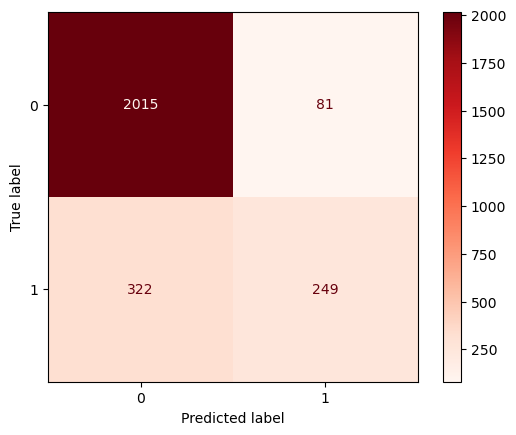

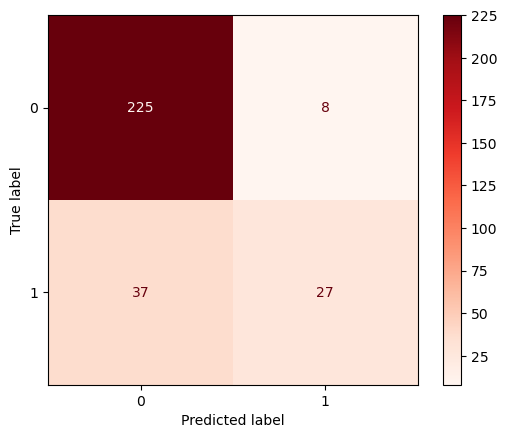

In [63]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import itertools

# Daftar kombinasi parameter yang akan dievaluasi secara manual
C_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
kernel_values = ['linear', 'rbf', 'sigmoid']
gamma_values = ['scale', 'auto']

best_f1_score = 0
best_params = {}

# Lakukan iterasi melalui semua kombinasi parameter yang ditentukan secara manual
for C, kernel, gamma in itertools.product(C_values, kernel_values, gamma_values):
    # Inisialisasi model SVC dengan parameter tertentu
    svc_model = SVC(C=C, kernel=kernel, gamma=gamma)
    
    # Latih model menggunakan data pelatihan
    svc_model.fit(X_train_final, y_train)
    
    # Lakukan prediksi pada data uji
    y_pred_test = svc_model.predict(X_test_final)
    
    # Hitung F1 score untuk model ini
    current_f1_score = f1_score(y_test, y_pred_test)
    
    # Bandingkan dengan F1 score terbaik yang telah dicapai sejauh ini
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_params = {'C': C, 'kernel': kernel, 'gamma': gamma}

# Setelah iterasi selesai, print parameter terbaik dan F1 score terbaik
print("Best Parameter:")
print(best_params, '\n')
print('Best F1 Score:', best_f1_score)

# Gunakan parameter terbaik untuk melatih model final
best_svc_model = SVC(**best_params, random_state=42)
best_svc_model.fit(X_train_final, y_train)

# Prediksi menggunakan model terbaik pada data pelatihan dan data uji
y_pred_train_best = best_svc_model.predict(X_train_final)
y_pred_test_best = best_svc_model.predict(X_test_final)

# Evaluasi performa menggunakan model terbaik pada data pelatihan dan data uji
print('F1 Score - Train Set (Best SVC): ', f1_score(y_train, y_pred_train_best))
print('F1 Score - Test Set (Best SVC): ', f1_score(y_test, y_pred_test_best))

# Check Performance Model against Train-Set
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_train_final, y_train, cmap='Reds'))

# Check Performance Model against Test-Set
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_test_final, y_test, cmap='Reds'))

Lalu saya akan melakukan hyperparameter tuning dengan menggunakan `Random Search` yang bertujuan untuk meningkatkan score dari best model (SVM). 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best Parameter:
{'kernel': 'rbf', 'gamma': 'scale', 'C': 3.0} 

F1 Score - Train Set (Best SVC):  0.5530973451327433
F1 Score - Test Set (Best SVC):  0.5454545454545454
Confusion Matrix      : 
Confusion Matrix      : 


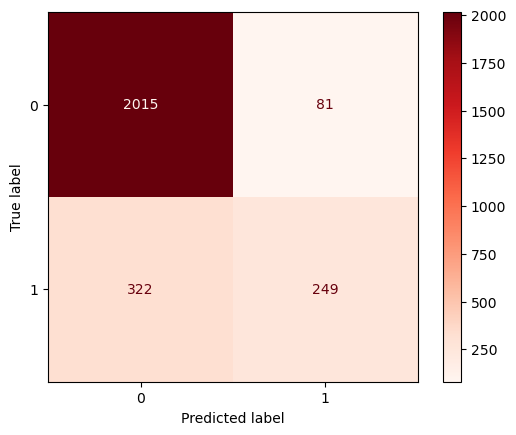

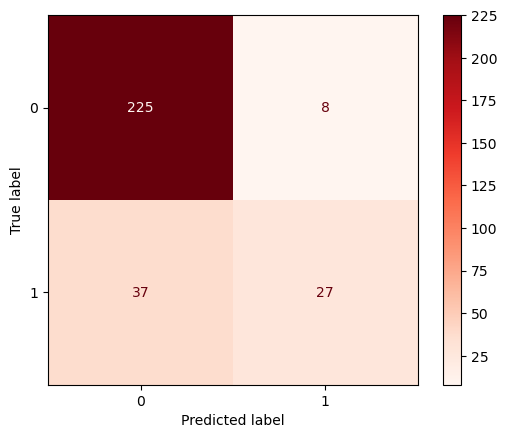

In [64]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Daftar hyperparameter yang akan dioptimalkan
param_grid = {
    'C': np.linspace(1, 10, num=10),  # Range untuk C dari 1 hingga 10
    'kernel': ['linear', 'rbf', 'sigmoid'],  # Pilihan kernel
    'gamma': ['scale', 'auto']  # Pilihan gamma
}

# Inisialisasi RandomizedSearchCV untuk pencarian parameter terbaik
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_grid,
    scoring='f1',
    cv=5,
    n_iter=10,  # Jumlah iterasi pencarian acak
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Lakukan Randomized Search untuk mencari kombinasi parameter terbaik
random_search.fit(X_train_final, y_train)

# Dapatkan parameter terbaik setelah Randomized Search selesai
best_params = random_search.best_params_
print("Best Parameter:")
print(best_params, '\n')

# Prediksi menggunakan model dengan parameter terbaik
best_svc_model = random_search.best_estimator_

# Prediksi menggunakan model terbaik pada data pelatihan dan data uji
y_pred_train_best = best_svc_model.predict(X_train_final)
y_pred_test_best = best_svc_model.predict(X_test_final)

# Evaluasi performa menggunakan model terbaik pada data pelatihan dan data uji
print('F1 Score - Train Set (Best SVC): ', f1_score(y_train, y_pred_train_best))
print('F1 Score - Test Set (Best SVC): ', f1_score(y_test, y_pred_test_best))

# Check Performance Model against Train-Set
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_train_final, y_train, cmap='Reds'))

# Check Performance Model against Test-Set
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_svc, X_test_final, y_test, cmap='Reds'))

In [ ]:
# Save Classification Report into a Dictionary
all_reports = performance_report(all_reports, y_train, y_pred_train_best, y_test, y_pred_test_best, 'GridSearchCV')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),GridSearchCV
train - f1_score,0.534078,0.552719
test - f1_score,0.540000,0.545455


Setelah melakukan proses Hyperparameter tuning nilai F1 score menjadi:
- **F1 Score - Train Set (Best Logistic Regression)**  :  0.5527192008879024
- **F1 Score - Test Set (Best Logistic Regression)**   :  0.5454545454545454 

Dan best parameternya yaitu:
- **'svc__C': 2**
- **'svc__gamma': 'auto'**
- **'svc__kernel': 'rbf'**

Dari proses sebelum dan sesudah Hyperparameter tuning dapat disimpulkan bahwa mengalami kenaikan score pada F1 score sebesar:
- **Train set** : 0.0186409885973996
- **Test set** : 0.005454545454545379

Dari Hasil confusion matrix:
- **Train set** : False Negatif mengalami penurunan
- **Test set**  :False Negatif mengalami penurunan

yang artinya proses Hyperparameter tuning **berhasil**.

# x. Model Saving

Lalu data best model yang telah dilakukan Hyperparameter tuning disimpan untuk dilakukan proses inference.

In [ ]:
# Save the files
with open ('best_svc.pkl', 'wb') as file_1: # wb = write binary
    pickle.dump(best_svc, file_1)

# xi. Model Inference

Penjelasan ada di notebook `P1G5_Set_1_Inference_Alfarabi.ipynb`

# xii. Conclusion

1. `Pejelasan Metric`: Matriks F1 Score digunakan karena memberikan pengukuran yang seimbang antara presisi (precision) dan recall. Hal ini berguna ketika kita memiliki dataset yang tidak seimbang (imbalanced dataset), di mana kelas positif dan negatif memiliki distribusi yang berbeda. F1 Score menggabungkan presisi dan recall menjadi satu metrik, sehingga cocok digunakan untuk evaluasi performa model pada kasus seperti default kartu kredit di mana kelas yang positif (default) mungkin lebih sedikit daripada yang negatif (non-default). Pada kasus ini, F1 Score akan memberikan nilai yang lebih baik daripada akurasi (accuracy) atau recall. Sebelum melakukan nilai F1 score pada Train set sebesar 0.534078 setelah melakukan tuning baik menjadi 0.552719, dan pada Test set nilai F1 score sebesar 0.534078 setelah melakukan tuning baik menjadi 0.552719.

2. `Evaluasi Model`:
   1. **Kelebihan Model SVM**:
   - Mampu Menangani Pola Nonlinear: SVM dapat mengatasi pola data yang kompleks dan tidak linear, yang sering terjadi dalam data kredit kartu.
   - Efisien untuk Data dengan Banyak Fitur: SVM efektif digunakan pada dataset dengan banyak fitur (variabel), seperti data kredit kartu, karena menggunakan subset data penting untuk membuat keputusan.
   - Dapat Mengendalikan Overfitting: SVM dapat mengendalikan overfitting (ketika model terlalu cocok dengan data pelatihan) melalui parameter seperti C (cost) dan kernel yang tepat.
   2. **Kelemahan Model SVM**:
   - Butuh Pemilihan Kernel yang Tepat: Performa SVM sangat tergantung pada pemilihan kernel yang sesuai dengan data. Pemilihan yang salah dapat mempengaruhi hasil model.
   - Sensitif terhadap Skala dan Noise: SVM rentan terhadap perbedaan skala antar variabel dan keberadaan noise dalam data. Skala yang tidak seimbang atau noise dapat memengaruhi performa model.
   - Penyetelan Parameter yang Rumit: Menyetel parameter SVM (seperti C dan gamma) membutuhkan uji coba yang cermat terutama pada data yang kompleks seperti kredit kartu default.

3. `Improvement Model`:
   1. **Pemilihan Kernel**: Coba variasi jenis "kernel" yang digunakan dalam SVM, seperti linear, polynomial, atau radial basis function (RBF), untuk menemukan yang paling cocok dengan pola data kartu kredit.
   2. **Penyetelan Parameter**: Lakukan penyetelan parameter SVM dengan hati-hati, seperti parameter C (cost) dan gamma untuk kernel RBF. Gunakan teknik seperti GridSearchCV untuk menemukan kombinasi parameter terbaik. 
   3. **Penanganan Ketidakseimbangan Kelas**: Jika jumlah default dan non-default tidak seimbang, pertimbangkan teknik untuk menyeimbangkan kelas target, seperti oversampling, undersampling, atau memberikan bobot berbeda pada kelas.
   4. **Normalisasi Data**: Pastikan data sudah dinormalisasi atau distandarisasi agar SVM dapat bekerja lebih baik dengan skala data yang berbeda.
   5. **Gabungan dengan Teknik Ensemble**: Gabungkan SVM dengan teknik ensemble seperti Random Forest atau Gradient Boosting untuk meningkatkan kestabilan dan performa prediksi.
   7. **Analisis Fitur**: Lakukan analisis lebih mendalam terhadap fitur-fitur yang paling penting dalam prediksi default kartu kredit. Mungkin perlu mengurangi fitur yang tidak terlalu berpengaruh.
   8. **Evaluasi dengan Metrik yang Lengkap**: Selain f1-score atau akurasi, gunakan metrik seperti ROC-AUC untuk mengevaluasi kemampuan model dalam membedakan kelas default dan non-default.

4. `Insight EDA`:
   - Berdasarkan pie chart sebagian besar (78,6%) pembayaran diperkirakan akan berhasil bulan depan.
   - Pengguna credit card terbanyak yaitu pada usia 30 tahun.
   - Semakin tinggi saldo limit semakin besar kemungkinan pembayaran yang gagal bulan depan.
   - Terdapat hubungan positif antara bill amount dengan payment amount pada bulan pertama.
   - Pengguna credit card terbanyak terletak pada education level 2 (University).

# xiii. Conceptual Problem

1. **Coeficient dalam logistic regression** adalah nilai-nilai yang menggambarkan seberapa besar pengaruh setiap fitur terhadap prediksi kejadian yang bersifat biner. Koefisien ini menunjukkan seberapa kuat dan dalam arah apa pengaruh setiap fitur terhadap hasil prediksi. Koefisien positif menunjukkan peningkatan probabilitas kejadian suatu peristiwa dengan peningkatan nilai fitur, sedangkan koefisien negatif menunjukkan hubungan sebaliknya. Dengan melihat koefisien, kita dapat menentukan variabel mana yang paling berpengaruh terhadap hasil prediksi dan mengerti arah serta kekuatan hubungannya dengan target yang diprediksi.

2. **Kernel dalam SVM** adalah parameter yang menentukan fungsi matematis untuk mengubah data ke dalam ruang dimensi yang lebih tinggi. Tujuan dari penggunaan kernel adalah untuk memungkinkan SVM memisahkan kelas data yang tidak dapat dipisahkan secara linear di ruang dimensi asli. Salah satu contoh kernel yang umum digunakan adalah kernel RBF. Dengan menggunakan kernel RBF, SVM dapat menemukan hiperplane yang optimal untuk memisahkan kelas data yang tidak linear. Ini memungkinkan SVM untuk melakukan klasifikasi yang lebih baik di berbagai jenis data yang kompleks dan tidak linear.

3. Untuk memilih nilai \( K \) yang optimal pada algoritma KNN, gunakan teknik validasi silang dengan membagi data menjadi subset pelatihan dan pengujian, kemudian evaluasi berbagai nilai \( K \) untuk memilih yang memberikan kinerja terbaik pada data validasi.

4. Pengertian metrik `Accuracy`,` Precision`, `Recall`, dan `F1 Score` dan waktu yang tepat untuk menggunakannya adalah sebagai berikut:
- **Accuracy**: Akurasi mengukur sejauh mana model mengklasifikasikan dengan benar (baik positif maupun negatif) dari semua prediksi yang dilakukan. Metrik ini cocok digunakan ketika kelas target di dataset seimbang, artinya jumlah sampel di setiap kelas tidak terlalu jauh berbeda.
- **Precision**: Presisi mengukur proporsi dari prediksi positif yang benar terhadap semua prediksi positif yang dilakukan oleh model. Presisi berguna ketika fokus pada kebutuhan untuk meminimalkan jumlah false positive, misalnya dalam kasus deteksi spam email.
- **Recall** : Recall mengukur proporsi dari prediksi positif yang benar terhadap semua instance yang benar positif dalam data aktual. Recall penting ketika fokus pada mendeteksi sebanyak mungkin instance positif, misalnya dalam deteksi penyakit diagnostik.
- **F1 Score**: F1 Score adalah rata-rata harmonik dari precision dan recall. Metrik ini menggabungkan kedua nilai ini menjadi satu skor tunggal yang bermanfaat ketika tidak ingin fokus terlalu banyak pada false positives atau false negatives. F1 Score cocok digunakan ketika dataset memiliki distribusi kelas yang tidak seimbang.





